# 

# Mini Project III - Twitter US Airline Sentiment Analysis 

# with Counter Vector and TF-IDF as Features

## Dataset

This data originally came from Crowdflower's Data for Everyone library(based on Kaggle.com),downloaded from www.kaggle.com. This dataset contains 15000 rows and 15 features.



### Import libraries

In [1]:
## Import Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import string
import spacy
import regex as re
from wordcloud import WordCloud, STOPWORDS

from collections import Counter

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
# import warnings
# warnings.filterwarnings('ignore')

%matplotlib inline

#### Load data

In [2]:
## Loading the data
df = pd.read_csv('./Data/Tweets.csv')
df.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## EDA

#### Inspect the data

- Check for
    - **Number of features**
    - **Data types**
    - **Domains, Intervals**
    - **Outliers** (are they valid or expurious data [read or measure errors])
  
    - **Missing Values** (coded [as zero of empty strings] or values not present)
    - **Coded content** (classes identified by numbers or codes to represent absence of data)


In [3]:
df.shape

(14640, 15)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

###### Check for **Null** values 

In [5]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

###### Drop Columns with more than 50% null values and unrelateed features for sentiment analysis

In [6]:
df_tweet=df.drop(['tweet_id' ,'airline_sentiment_confidence','negativereason_confidence','name','airline_sentiment_gold', 'negativereason_gold','retweet_count','tweet_coord','tweet_created','tweet_location','user_timezone'], axis = 1)

In [7]:
df_tweet.head()

,airline_sentiment,negativereason,airline,text
0,neutral,NaN,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,NaN,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,NaN,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Bad Flight,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,Can't Tell,Virgin America,@VirginAmerica and it's a really big bad thing...


In [8]:
# # Drop Null values in Negative reason
# df_tweet= df_tweet.dropna(axis=0, subset=['negativereason'])

In [9]:
df_tweet.isnull().sum()

airline_sentiment       0
negativereason       5462
airline                 0
text                    0
dtype: int64

###### Check for **Zero** values 

In [10]:
df_tweet.isin([0]).sum()

airline_sentiment    0
negativereason       0
airline              0
text                 0
dtype: int64

###### check for value counts in each column

In [11]:
df_tweet['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [12]:
df_tweet['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [13]:
df_tweet['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [14]:
# Select Data for Sentiment Analysis
df_tweet['airline_sentiment'] = df_tweet['airline_sentiment'].replace(['negative','neutral','positive'],[-1,0,1])                

In [15]:
df_tw=df_tweet.drop(['airline'], axis = 1)

In [16]:
# ANSWER
df_tw.head()

,airline_sentiment,negativereason,text
0,0,NaN,@VirginAmerica What @dhepburn said.
1,1,NaN,@VirginAmerica plus you've added commercials t...
2,0,NaN,@VirginAmerica I didn't today... Must mean I n...
3,-1,Bad Flight,@VirginAmerica it's really aggressive to blast...
4,-1,Can't Tell,@VirginAmerica and it's a really big bad thing...


In [17]:
df_tw.tail()

,airline_sentiment,negativereason,text
14635,1,NaN,@AmericanAir thank you we got on a different f...
14636,-1,Customer Service Issue,@AmericanAir leaving over 20 minutes Late Flig...
14637,0,NaN,@AmericanAir Please bring American Airlines to...
14638,-1,Customer Service Issue,"@AmericanAir you have my money, you change my ..."
14639,0,NaN,@AmericanAir we have 8 ppl so we need 2 know h...


In [18]:
df_tw.isnull().sum()

airline_sentiment       0
negativereason       5462
text                    0
dtype: int64

In [19]:
df_tw.shape

(14640, 3)

###### Data Cleaning for Analysis

###### Step 1 - Clean text

In [20]:
def clean_text(text):

    # remove double quotes
    text = re.sub(r'"', '', text)
    # remove @username 
    text = re.sub(r'@[\w]*','',text)
    # remove special characters, numbers, punctuations
    text = re.sub(r'[^a-zA-Z#]', ' ', text)
    # remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ' , text)
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)

    return text

In [21]:
# Clean Data
df_tw['text'] = df_tw['text'].apply(clean_text)

In [22]:
df_tw['text'].head(10)

0                                          What  said 
1     plus you ve added commercials to the experien...
2     didn today    Must mean need to take another ...
3     it really aggressive to blast obnoxious enter...
4               and it a really big bad thing about it
5     seriously would pay flight for seats that did...
6     yes  nearly every time fly VX this  ear worm ...
7     Really missed prime opportunity for Men Witho...
8                            Well didn but NOW DO    D
9     it was amazing  and arrived an hour early  Yo...
Name: text, dtype: object

###### Step 2 - Remove stop words, puctuations and  perform lemmatization

In [23]:
nlp = spacy.load('en_core_web_sm')

In [24]:
# remove stop words, puctuations and  perform lemmatization
def convert_text(text):
  
    doc = nlp(text)
    t = [w for w in doc if not (w.is_stop | w.is_punct)]
    x = [w.lemma_.lower() for w in t]

    s= " ".join(x)

    return s

In [25]:
%%time
df_tw['text'] = df_tw['text'].apply(convert_text)

Wall time: 1min 16s


In [26]:
df_tw['text'].head(10)

0                                                  say
1          plus ve add commercial experience     tacky
2                        didn today     mean need trip
3      aggressive blast obnoxious entertainment gue...
4                                        big bad thing
5      seriously pay flight seat didn play   bad th...
6      yes   nearly time fly vx   ear worm   win aw...
7      miss prime opportunity man hats parody     h...
8                                           didn     d
9                   amazing   arrive hour early   good
Name: text, dtype: object

## Split the data into train and test

In [27]:
## ANSWER
# Features and Labels
X = df_tw['text']
y = df_tw['airline_sentiment']
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Feature Engineering

### Count Vectors as features

In [28]:
# create a count vectorizer object
count_vect = CountVectorizer(token_pattern = r'\w{1,}')

# Learn a vocabulary dictionary of all tokens in the raw documents
count_vect.fit(df_tw['text'])

# Transform documents to document-term matrix.
X_train_count = count_vect.transform(X_train)
X_test_count = count_vect.transform(X_test)

In [29]:
X_train_count.shape

(11712, 10899)

In [30]:
X_train_count

<11712x10899 sparse matrix of type '<class 'numpy.int64'>'
	with 91210 stored elements in Compressed Sparse Row format>

### TF-IDF Vectors as features
- Word level
- N-Gram level
- Character level

In [31]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 5000)
print(tfidf_vect)

tfidf_vect.fit(df_tw['text'])
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf  = tfidf_vect.transform(X_test)

TfidfVectorizer(max_features=5000, token_pattern='\\w{1,}')
Wall time: 228 ms


In [32]:
%%time
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word',
                                   token_pattern = r'\w{1,}',
                                   ngram_range = (2, 3),
                                   max_features = 5000)
print(tfidf_vect_ngram)

tfidf_vect_ngram.fit(df_tw['text'])
X_train_tfidf_ngram = tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram  = tfidf_vect_ngram.transform(X_test)

TfidfVectorizer(max_features=5000, ngram_range=(2, 3), token_pattern='\\w{1,}')
Wall time: 738 ms


In [33]:
%%time
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer = 'char',
                                         token_pattern = r'\w{1,}',
                                         ngram_range = (2, 3),
                                         max_features = 5000)
print(tfidf_vect_ngram_chars)

tfidf_vect_ngram_chars.fit(df_tw['text'])
X_train_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(X_train)
X_test_tfidf_ngram_chars  = tfidf_vect_ngram_chars.transform(X_test)

TfidfVectorizer(analyzer='char', max_features=5000, ngram_range=(2, 3),
                token_pattern='\\w{1,}')


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:506: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


Wall time: 1.64 s


## Modelling

In [34]:
import time

In [35]:
# Model evaluation function
def evaluate_model(classifier, feature_vector_train, label_train, feature_vector_test,label_test):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label_train)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    
    # predict accuracy
    print(f" Accuracy Score for train data = {classifier.score(feature_vector_train, label_train)}")
    print(f" Accuracy Score for test data = {classifier.score(feature_vector_test, label_test)}")
    
    
    # confusion matrix
    log_cm = metrics.confusion_matrix(label_test, predictions,[-1,0,1])
    sns.heatmap(log_cm, annot=True, fmt='.2f',xticklabels = ["Negative","Neutral", "Positive"] , yticklabels = ["Negative","Neutral", "Positive"],cmap='Blues' )
    plt.title('Confusion Matrics')
    plt.savefig('cm')
    
   
    # Classification Report for test data
    print("Classification Report for test data")
    print(classification_report(label_test, predictions))
    
    return classifier.score(feature_vector_test, label_test)


In [36]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Count Vectors',
                                  'WordLevel TF-IDF',
                                  'N-Gram Vectors',
                                  'CharLevel Vectors'])

### Naive Bayes Classifier

#### Count Vectors

In [37]:
%%time
# Naive Bayes on Count Vectors
mnb_model = MultinomialNB()
mnb_model.fit( X_train_count, y_train)
# Score

print(f" Accuracy Score for train data = {mnb_model.score(X_train_count, y_train)}")
print(f" Accuracy Score for test data = {mnb_model.score(X_test_count , y_test)}")

 Accuracy Score for train data = 0.8237704918032787
 Accuracy Score for test data = 0.7711748633879781
Wall time: 7.01 ms


#### Naive Bayes Classifier Hyperparameter tuning on count vectors

In [38]:
nvb_params = {
    'fit_prior': [True, False],
    'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]
}
nvb=MultinomialNB()
nvb_cv=GridSearchCV(nvb,nvb_params, cv=5, verbose=0)
best_model = nvb_cv.fit(X_train_count,y_train)
result = best_model.cv_results_
pd.DataFrame.from_dict(result).T


,0,1,2,3,4,5,6,7,8,9
mean_fit_time,0.003206,0.003,0.003001,0.003001,0.002798,0.002798,0.003002,0.003003,0.003001,0.002801
std_fit_time,0.000407,0.000008,0.0,0.000008,0.000399,0.000399,0.000006,0.00001,0.000003,0.0004
mean_score_time,0.000199,0.000603,0.0002,0.0004,0.000603,0.000603,0.000599,0.000797,0.0004,0.0006
std_score_time,0.000397,0.000492,0.0004,0.00049,0.000492,0.000492,0.000489,0.000398,0.00049,0.00049
param_alpha,0.01,0.01,0.1,0.1,0.5,0.5,1.0,1.0,10.0,10.0
param_fit_prior,True,False,True,False,True,False,True,False,True,False
params,"{'alpha': 0.01, 'fit_prior': True}","{'alpha': 0.01, 'fit_prior': False}","{'alpha': 0.1, 'fit_prior': True}","{'alpha': 0.1, 'fit_prior': False}","{'alpha': 0.5, 'fit_prior': True}","{'alpha': 0.5, 'fit_prior': False}","{'alpha': 1.0, 'fit_prior': True}","{'alpha': 1.0, 'fit_prior': False}","{'alpha': 10.0, 'fit_prior': True}","{'alpha': 10.0, 'fit_prior': False}"
split0_test_score,0.7277,0.709774,0.736236,0.719163,0.750747,0.735382,0.74093,0.748186,0.655997,0.701665
split1_test_score,0.719163,0.708067,0.733675,0.718737,0.745625,0.744772,0.737516,0.74904,0.650875,0.697823
split2_test_score,0.722032,0.712212,0.73228,0.714774,0.74936,0.737404,0.744236,0.747652,0.654996,0.690009


 Accuracy Score for train data = 0.8364071038251366
 Accuracy Score for test data = 0.769808743169399
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.84      0.87      0.86      1889
           0       0.58      0.48      0.53       580
           1       0.67      0.71      0.69       459

    accuracy                           0.77      2928
   macro avg       0.70      0.69      0.69      2928
weighted avg       0.76      0.77      0.76      2928



C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Wall time: 185 ms


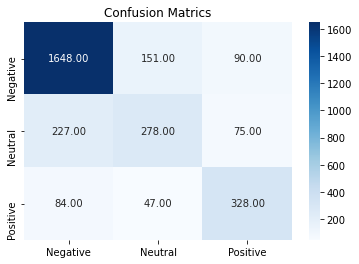

In [39]:
%%time
# Naive Bayes on Count Vectors
accuracy1 = evaluate_model(MultinomialNB(alpha = 1.0, fit_prior= False), X_train_count, y_train,X_test_count , y_test)

#### On Word Level TF IDF Vectors

In [40]:
%%time
# Naive Bayes on word Level TF IDF Vectors
mnb_modeltf = MultinomialNB()
mnb_modeltf.fit( X_train_tfidf, y_train)
# Score

print(f" Accuracy Score for train data = {mnb_modeltf.score(X_train_tfidf, y_train)}")
print(f" Accuracy Score for test data = {mnb_modeltf.score(X_test_tfidf , y_test)}")

 Accuracy Score for train data = 0.7613558743169399
 Accuracy Score for test data = 0.73224043715847
Wall time: 5 ms


##### Hyperparameter tuning on Word Level TF IDF Vectors

In [41]:
nvb_params = {
    'fit_prior': [True, False],
    'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]
}
nvb=MultinomialNB()
nvb_cv=GridSearchCV(nvb,nvb_params, cv=5, verbose=0)
best_model = nvb_cv.fit(X_train_tfidf,y_train)
result = best_model.cv_results_
pd.DataFrame.from_dict(result).T

,0,1,2,3,4,5,6,7,8,9
mean_fit_time,0.0032,0.003,0.003201,0.0028,0.0026,0.0026,0.0028,0.003,0.003,0.002601
std_fit_time,0.000749,0.000001,0.0004,0.0004,0.00049,0.00049,0.0004,0.0,0.000001,0.000489
mean_score_time,0.0004,0.0006,0.0002,0.000601,0.0004,0.0006,0.000601,0.0004,0.0002,0.000399
std_score_time,0.00049,0.00049,0.0004,0.00049,0.00049,0.00049,0.00049,0.00049,0.000401,0.000489
param_alpha,0.01,0.01,0.1,0.1,0.5,0.5,1.0,1.0,10.0,10.0
param_fit_prior,True,False,True,False,True,False,True,False,True,False
params,"{'alpha': 0.01, 'fit_prior': True}","{'alpha': 0.01, 'fit_prior': False}","{'alpha': 0.1, 'fit_prior': True}","{'alpha': 0.1, 'fit_prior': False}","{'alpha': 0.5, 'fit_prior': True}","{'alpha': 0.5, 'fit_prior': False}","{'alpha': 1.0, 'fit_prior': True}","{'alpha': 1.0, 'fit_prior': False}","{'alpha': 10.0, 'fit_prior': True}","{'alpha': 10.0, 'fit_prior': False}"
split0_test_score,0.7277,0.705506,0.73965,0.713188,0.728553,0.731114,0.70892,0.744345,0.639778,0.723431
split1_test_score,0.7277,0.710201,0.735382,0.71831,0.721724,0.741784,0.706786,0.749893,0.642766,0.717456
split2_test_score,0.730572,0.705807,0.746798,0.709223,0.734842,0.724167,0.707942,0.74082,0.639197,0.712639


 Accuracy Score for train data = 0.8243681693989071
 Accuracy Score for test data = 0.769808743169399
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.85      0.86      0.86      1889
           0       0.58      0.52      0.55       580
           1       0.67      0.70      0.69       459

    accuracy                           0.77      2928
   macro avg       0.70      0.69      0.70      2928
weighted avg       0.77      0.77      0.77      2928

Wall time: 172 ms


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


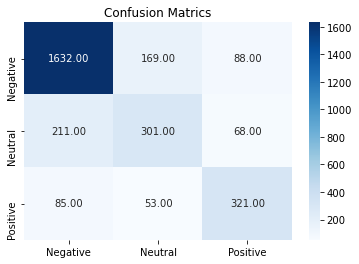

In [42]:
%%time
# Naive Bayes on word Level TF IDF Vectors
accuracy2 = evaluate_model(MultinomialNB(alpha = 1.0, fit_prior= False), X_train_tfidf, y_train,X_test_tfidf  , y_test)

#### on Ngram Level TF IDF Vectors

In [43]:
%%time
# Naive Bayes on Ngram Level TF IDF Vectors
mnb_modelnf = MultinomialNB()
mnb_modelnf.fit(X_train_tfidf_ngram, y_train)
# Score
# accuracy2 = mnb_modelnf.score(X_test_tfidf_ngram , y_test)
print(f" Accuracy Score for train data = {mnb_modelnf.score(X_train_tfidf_ngram, y_train)}")
print(f" Accuracy Score for test data = {mnb_modelnf.score(X_test_tfidf_ngram , y_test)}")

 Accuracy Score for train data = 0.7318135245901639
 Accuracy Score for test data = 0.7021857923497268
Wall time: 5.02 ms


##### Hyperparameter tuning on Ngram Level TF IDF Vectors

In [44]:
nvb_params = {
    'fit_prior': [True, False],
    'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]
}
nvb=MultinomialNB()
nvb_cv=GridSearchCV(nvb,nvb_params, cv=5, verbose=0)
best_model = nvb_cv.fit(X_train_tfidf_ngram,y_train)
result = best_model.cv_results_
pd.DataFrame.from_dict(result).T

,0,1,2,3,4,5,6,7,8,9
mean_fit_time,0.002599,0.002399,0.002399,0.0028,0.002421,0.00238,0.002598,0.014803,0.002376,0.002402
std_fit_time,0.000492,0.000484,0.000488,0.0004,0.000516,0.000466,0.000488,0.02461,0.000462,0.000489
mean_score_time,0.000604,0.0004,0.0006,0.0002,0.000401,0.0004,0.0002,0.0006,0.0004,0.000399
std_score_time,0.000493,0.00049,0.00049,0.0004,0.000491,0.00049,0.0004,0.00049,0.00049,0.000489
param_alpha,0.01,0.01,0.1,0.1,0.5,0.5,1.0,1.0,10.0,10.0
param_fit_prior,True,False,True,False,True,False,True,False,True,False
params,"{'alpha': 0.01, 'fit_prior': True}","{'alpha': 0.01, 'fit_prior': False}","{'alpha': 0.1, 'fit_prior': True}","{'alpha': 0.1, 'fit_prior': False}","{'alpha': 0.5, 'fit_prior': True}","{'alpha': 0.5, 'fit_prior': False}","{'alpha': 1.0, 'fit_prior': True}","{'alpha': 1.0, 'fit_prior': False}","{'alpha': 10.0, 'fit_prior': True}","{'alpha': 10.0, 'fit_prior': False}"
split0_test_score,0.652582,0.617584,0.663252,0.607341,0.681605,0.573624,0.683312,0.573197,0.626547,0.598805
split1_test_score,0.66624,0.63551,0.673922,0.625694,0.675203,0.601793,0.680751,0.594964,0.629108,0.60478
split2_test_score,0.658412,0.625534,0.663962,0.604184,0.678053,0.581981,0.678053,0.579846,0.628523,0.588813


 Accuracy Score for train data = 0.7318135245901639
 Accuracy Score for test data = 0.7021857923497268
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.71      0.96      0.81      1889
           0       0.62      0.19      0.30       580
           1       0.74      0.27      0.40       459

    accuracy                           0.70      2928
   macro avg       0.69      0.48      0.50      2928
weighted avg       0.69      0.70      0.65      2928

Wall time: 164 ms


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


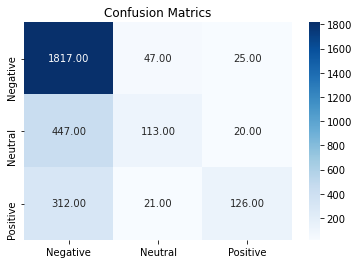

In [45]:
%%time
# Naive Bayes on Ngram Level TF IDF Vectors
accuracy3 = evaluate_model(MultinomialNB(alpha = 1.0, fit_prior= True), X_train_tfidf_ngram, y_train,X_test_tfidf_ngram  , y_test)

#### on CharacterLevel TF IDF Vectors

In [46]:
%%time
# Naive Bayes on Character Level TF IDF Vectors
mnb_modelcf = MultinomialNB()
mnb_modelcf.fit(X_train_tfidf_ngram_chars, y_train)
# Score
# accuracy2 = mnb_modelcf.score(X_test_tfidf_ngram_chars , y_test)
print(f" Accuracy Score for train data = {mnb_modelcf.score(X_train_tfidf_ngram_chars, y_train)}")
print(f" Accuracy Score for test data = {mnb_modelcf.score(X_test_tfidf_ngram_chars , y_test)}")

 Accuracy Score for train data = 0.7365949453551912
 Accuracy Score for test data = 0.7370218579234973
Wall time: 13.2 ms


##### Hyperparameter tuning on Character Level TF IDF Vectors

In [47]:
nvb_params = {
    'fit_prior': [True, False],
    'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]
}
nvb=MultinomialNB()
nvb_cv=GridSearchCV(nvb,nvb_params, cv=5, verbose=0)
best_model = nvb_cv.fit(X_train_tfidf_ngram_chars,y_train)
result = best_model.cv_results_
pd.DataFrame.from_dict(result).T

,0,1,2,3,4,5,6,7,8,9
mean_fit_time,0.008212,0.008401,0.008603,0.008204,0.009202,0.008204,0.009403,0.008403,0.008204,0.008201
std_fit_time,0.000402,0.000489,0.00049,0.0004,0.001937,0.0004,0.001019,0.000491,0.0004,0.0004
mean_score_time,0.001594,0.0012,0.001199,0.001399,0.001398,0.001399,0.0016,0.001199,0.001399,0.001201
std_score_time,0.000485,0.000399,0.0004,0.000489,0.00049,0.00049,0.000491,0.000401,0.000491,0.000399
param_alpha,0.01,0.01,0.1,0.1,0.5,0.5,1.0,1.0,10.0,10.0
param_fit_prior,True,False,True,False,True,False,True,False,True,False
params,"{'alpha': 0.01, 'fit_prior': True}","{'alpha': 0.01, 'fit_prior': False}","{'alpha': 0.1, 'fit_prior': True}","{'alpha': 0.1, 'fit_prior': False}","{'alpha': 0.5, 'fit_prior': True}","{'alpha': 0.5, 'fit_prior': False}","{'alpha': 1.0, 'fit_prior': True}","{'alpha': 1.0, 'fit_prior': False}","{'alpha': 10.0, 'fit_prior': True}","{'alpha': 10.0, 'fit_prior': False}"
split0_test_score,0.73026,0.70892,0.731968,0.702091,0.722151,0.704652,0.716603,0.716176,0.641485,0.664106
split1_test_score,0.72898,0.731541,0.729834,0.734102,0.722578,0.734102,0.711054,0.738796,0.644046,0.664106
split2_test_score,0.732707,0.715628,0.731853,0.712639,0.727583,0.717336,0.715628,0.724594,0.642186,0.665243


 Accuracy Score for train data = 0.7797131147540983
 Accuracy Score for test data = 0.7517076502732241
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.77      0.94      0.84      1889
           0       0.57      0.34      0.43       580
           1       0.84      0.51      0.63       459

    accuracy                           0.75      2928
   macro avg       0.73      0.60      0.63      2928
weighted avg       0.74      0.75      0.73      2928

Wall time: 176 ms


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


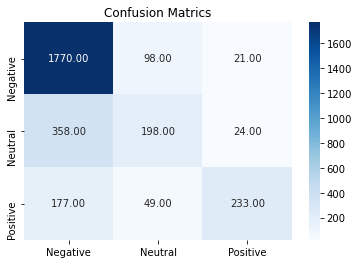

In [48]:
%%time
# Naive Bayes on Character Level TF IDF Vectors
accuracy4 = evaluate_model(MultinomialNB(alpha = 0.01, fit_prior= True), X_train_tfidf_ngram_chars, y_train,X_test_tfidf_ngram_chars  , y_test)

In [49]:
results.loc['Naïve Bayes'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [50]:
results

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors
Naïve Bayes,0.769809,0.769809,0.702186,0.751708


### Linear Classifier

#### Count Vectors

In [51]:
model = LogisticRegression(solver='liblinear')
# Fit Model
model.fit(X_train_count,y_train)
# Score

print(f" Accuracy Score for train data = {model.score(X_train_count, y_train)}")
print(f" Accuracy Score for test data = {model.score(X_test_count , y_test)}")

 Accuracy Score for train data = 0.8977117486338798
 Accuracy Score for test data = 0.7971311475409836


#### Linear Classifier Hyperparameter tuning on count vectors

In [52]:
# use GridSearchCV to find best hyper parameters

In [53]:
lr_params = {'penalty': ['l1','l2'],'C': [0.001,0.1,1, 10, 100]}

logreg=LogisticRegression(max_iter=10000,solver='liblinear')
logreg_cv=GridSearchCV(logreg,lr_params, cv=5, verbose=0)
best_model = logreg_cv.fit(X_train_count,y_train)
result = best_model.cv_results_
pd.DataFrame.from_dict(result).T

,0,1,2,3,4,5,6,7,8,9
mean_fit_time,0.015804,0.019204,0.04411,0.049011,0.057417,0.090616,0.125337,0.168038,0.193747,0.360478
std_fit_time,0.000752,0.00098,0.00516,0.000633,0.004035,0.001745,0.017016,0.010938,0.00609,0.032979
mean_score_time,0.0002,0.0004,0.000601,0.0,0.0008,0.0004,0.000999,0.0008,0.000802,0.0004
std_score_time,0.000401,0.00049,0.00049,0.0,0.0004,0.00049,0.000006,0.0004,0.000401,0.00049
param_C,0.001,0.001,0.1,0.1,1,1,10,10,100,100
param_penalty,l1,l2,l1,l2,l1,l2,l1,l2,l1,l2
params,"{'C': 0.001, 'penalty': 'l1'}","{'C': 0.001, 'penalty': 'l2'}","{'C': 0.1, 'penalty': 'l1'}","{'C': 0.1, 'penalty': 'l2'}","{'C': 1, 'penalty': 'l1'}","{'C': 1, 'penalty': 'l2'}","{'C': 10, 'penalty': 'l1'}","{'C': 10, 'penalty': 'l2'}","{'C': 100, 'penalty': 'l1'}","{'C': 100, 'penalty': 'l2'}"
split0_test_score,0.622279,0.623133,0.721724,0.758003,0.776355,0.777636,0.75032,0.761417,0.69697,0.724712
split1_test_score,0.622279,0.623133,0.734528,0.764831,0.778916,0.780196,0.737516,0.753308,0.697397,0.734102
split2_test_score,0.622545,0.622972,0.715628,0.750213,0.761742,0.76772,0.744236,0.757472,0.711358,0.735696


 Accuracy Score for train data = 0.8977117486338798
 Accuracy Score for test data = 0.7971311475409836
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.85      0.90      0.87      1889
           0       0.63      0.54      0.58       580
           1       0.75      0.69      0.72       459

    accuracy                           0.80      2928
   macro avg       0.74      0.71      0.73      2928
weighted avg       0.79      0.80      0.79      2928

Wall time: 279 ms


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


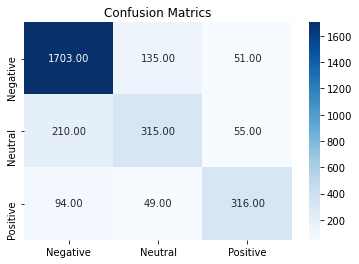

In [54]:
%%time
# Logistic Regression on Count Vectors
accuracy1 = evaluate_model(LogisticRegression(C=1, penalty='l2',solver='liblinear'), X_train_count, y_train,X_test_count , y_test)

#### On Word Level TF IDF Vectors

In [55]:
%%time
model = LogisticRegression(solver='liblinear', max_iter = 500)
# Fit Model
model.fit( X_train_tfidf,y_train)
# Score

print(f" Accuracy Score for train data = {model.score( X_train_tfidf, y_train)}")
print(f" Accuracy Score for test data = {model.score(X_test_tfidf , y_test)}")

 Accuracy Score for train data = 0.8257342896174863
 Accuracy Score for test data = 0.7865437158469946
Wall time: 55 ms


##### Hyperparameter tuning on Word Level TF IDF Vectors

In [56]:
lr_params = {'penalty': ['l1','l2'],'C': [0.001,0.1,1, 10, 100]}

logreg=LogisticRegression(max_iter=10000,solver='liblinear')
logreg_cv=GridSearchCV(logreg,lr_params, cv=5, verbose=0)
best_model = logreg_cv.fit(X_train_tfidf,y_train)
result = best_model.cv_results_
pd.DataFrame.from_dict(result).T

,0,1,2,3,4,5,6,7,8,9
mean_fit_time,0.012201,0.013002,0.026205,0.028403,0.042809,0.042716,0.119228,0.079618,0.23018,0.15493
std_fit_time,0.000401,0.000001,0.001167,0.00049,0.003487,0.000398,0.002135,0.003387,0.018405,0.00565
mean_score_time,0.000802,0.001001,0.000802,0.000401,0.000799,0.000803,0.000802,0.000603,0.0002,0.0006
std_score_time,0.000401,0.000001,0.000401,0.000491,0.0004,0.000401,0.000401,0.000492,0.0004,0.00049
param_C,0.001,0.001,0.1,0.1,1,1,10,10,100,100
param_penalty,l1,l2,l1,l2,l1,l2,l1,l2,l1,l2
params,"{'C': 0.001, 'penalty': 'l1'}","{'C': 0.001, 'penalty': 'l2'}","{'C': 0.1, 'penalty': 'l1'}","{'C': 0.1, 'penalty': 'l2'}","{'C': 1, 'penalty': 'l1'}","{'C': 1, 'penalty': 'l2'}","{'C': 10, 'penalty': 'l1'}","{'C': 10, 'penalty': 'l2'}","{'C': 100, 'penalty': 'l1'}","{'C': 100, 'penalty': 'l2'}"
split0_test_score,0.622279,0.622279,0.684592,0.682885,0.756722,0.763978,0.75032,0.772087,0.690141,0.733675
split1_test_score,0.622279,0.622279,0.699104,0.684592,0.762271,0.770807,0.731968,0.766539,0.690568,0.723005
split2_test_score,0.622545,0.622545,0.690009,0.684885,0.752348,0.758753,0.739966,0.763877,0.701537,0.728864


 Accuracy Score for train data = 0.9073599726775956
 Accuracy Score for test data = 0.7930327868852459
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.84      0.90      0.87      1889
           0       0.61      0.54      0.57       580
           1       0.77      0.66      0.71       459

    accuracy                           0.79      2928
   macro avg       0.74      0.70      0.72      2928
weighted avg       0.79      0.79      0.79      2928

Wall time: 289 ms


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


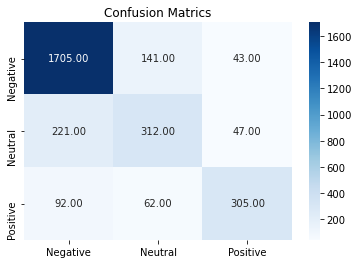

In [57]:
%%time
# Logistic Regression on TF IDF
accuracy2 = evaluate_model(LogisticRegression(C=10, penalty='l2',solver='liblinear'),  X_train_tfidf, y_train,X_test_tfidf , y_test)

#### on Ngram Level TF IDF Vectors

In [58]:
modeln = LogisticRegression(solver='liblinear')
# Fit Model
modeln.fit(X_train_tfidf_ngram,y_train)
# Score

print(f" Accuracy Score for train data = {modeln.score(X_train_tfidf_ngram, y_train)}")
print(f" Accuracy Score for test data = {modeln.score(X_test_tfidf_ngram , y_test)}")

 Accuracy Score for train data = 0.7155054644808743
 Accuracy Score for test data = 0.6956967213114754


##### Hyperparameter tuning on Ngram Level TF IDF Vectors

In [59]:
lr_params = {'penalty': ['l1','l2'],'C': [0.001,0.1,1, 10, 100]}

logreg=LogisticRegression(max_iter=10000,solver='liblinear')
logreg_cv=GridSearchCV(logreg,lr_params, cv=5, verbose=0)
best_model = logreg_cv.fit(X_train_tfidf_ngram,y_train)
result = best_model.cv_results_
pd.DataFrame.from_dict(result).T

,0,1,2,3,4,5,6,7,8,9
mean_fit_time,0.008201,0.011402,0.012201,0.021804,0.020204,0.033406,0.049712,0.066816,0.103822,0.140429
std_fit_time,0.0004,0.000491,0.00098,0.0004,0.001327,0.00206,0.006226,0.004702,0.014413,0.010824
mean_score_time,0.0002,0.0002,0.000601,0.000801,0.000801,0.000601,0.0004,0.0006,0.000601,0.0006
std_score_time,0.0004,0.0004,0.000491,0.0004,0.0004,0.000491,0.00049,0.00049,0.000491,0.00049
param_C,0.001,0.001,0.1,0.1,1,1,10,10,100,100
param_penalty,l1,l2,l1,l2,l1,l2,l1,l2,l1,l2
params,"{'C': 0.001, 'penalty': 'l1'}","{'C': 0.001, 'penalty': 'l2'}","{'C': 0.1, 'penalty': 'l1'}","{'C': 0.1, 'penalty': 'l2'}","{'C': 1, 'penalty': 'l1'}","{'C': 1, 'penalty': 'l2'}","{'C': 10, 'penalty': 'l1'}","{'C': 10, 'penalty': 'l2'}","{'C': 100, 'penalty': 'l1'}","{'C': 100, 'penalty': 'l2'}"
split0_test_score,0.622279,0.622279,0.629962,0.629962,0.661118,0.672642,0.652155,0.664533,0.629108,0.638071
split1_test_score,0.622279,0.622279,0.634656,0.63679,0.665813,0.676483,0.644046,0.659411,0.624413,0.635937
split2_test_score,0.622545,0.622545,0.62895,0.631085,0.663535,0.670794,0.637489,0.658412,0.61614,0.627669


 Accuracy Score for train data = 0.7155054644808743
 Accuracy Score for test data = 0.6956967213114754
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.70      0.96      0.81      1889
           0       0.58      0.21      0.30       580
           1       0.80      0.22      0.35       459

    accuracy                           0.70      2928
   macro avg       0.69      0.46      0.49      2928
weighted avg       0.69      0.70      0.64      2928

Wall time: 206 ms


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


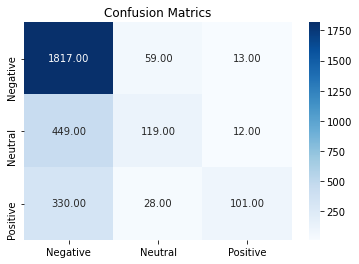

In [60]:
%%time
# Logistic Regression on Ngram Level
accuracy3 = evaluate_model(LogisticRegression(C=1, penalty='l2',solver='liblinear'),  X_train_tfidf_ngram, y_train,X_test_tfidf_ngram , y_test)

#### on Character Level Level TF IDF Vectors

In [61]:
modelc = LogisticRegression(solver='liblinear')
# Fit Model
modelc.fit(X_train_tfidf_ngram_chars,y_train)
# Score

print(f" Accuracy Score for train data = {modelc.score(X_train_tfidf_ngram_chars, y_train)}")
print(f" Accuracy Score for test data = {modelc.score(X_test_tfidf_ngram_chars , y_test)}")

 Accuracy Score for train data = 0.8048155737704918
 Accuracy Score for test data = 0.7718579234972678


##### Hyperparameter tuning on Character Level TF IDF Vectors

In [62]:
lr_params = {'penalty': ['l1','l2'],'C': [0.001,0.1,1, 10, 100]}

logreg=LogisticRegression(max_iter=10000,solver='liblinear')
logreg_cv=GridSearchCV(logreg,lr_params, cv=5, verbose=0)
best_model = logreg_cv.fit(X_train_tfidf_ngram_chars,y_train)
result = best_model.cv_results_
pd.DataFrame.from_dict(result).T

,0,1,2,3,4,5,6,7,8,9
mean_fit_time,0.074422,0.086666,0.153536,0.218158,0.299303,0.379788,1.066873,0.701467,6.062872,1.377035
std_fit_time,0.003928,0.000534,0.002682,0.006629,0.018252,0.01136,0.014061,0.022837,0.431507,0.0575
mean_score_time,0.001194,0.001598,0.001204,0.001397,0.00119,0.0014,0.001401,0.0012,0.001202,0.001001
std_score_time,0.000393,0.000488,0.000398,0.000485,0.000406,0.000489,0.000489,0.0004,0.000402,0.0
param_C,0.001,0.001,0.1,0.1,1,1,10,10,100,100
param_penalty,l1,l2,l1,l2,l1,l2,l1,l2,l1,l2
params,"{'C': 0.001, 'penalty': 'l1'}","{'C': 0.001, 'penalty': 'l2'}","{'C': 0.1, 'penalty': 'l1'}","{'C': 0.1, 'penalty': 'l2'}","{'C': 1, 'penalty': 'l1'}","{'C': 1, 'penalty': 'l2'}","{'C': 10, 'penalty': 'l1'}","{'C': 10, 'penalty': 'l2'}","{'C': 100, 'penalty': 'l1'}","{'C': 100, 'penalty': 'l2'}"
split0_test_score,0.622279,0.622279,0.66624,0.689714,0.749466,0.756295,0.737516,0.761844,0.690568,0.733248
split1_test_score,0.622279,0.622279,0.672642,0.702091,0.759283,0.758429,0.739223,0.759283,0.685446,0.725992
split2_test_score,0.622545,0.622545,0.665243,0.69257,0.748079,0.755764,0.745517,0.758326,0.704099,0.734415


 Accuracy Score for train data = 0.8789275956284153
 Accuracy Score for test data = 0.7844945355191257
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.83      0.91      0.87      1889
           0       0.59      0.49      0.54       580
           1       0.76      0.66      0.71       459

    accuracy                           0.78      2928
   macro avg       0.73      0.68      0.70      2928
weighted avg       0.77      0.78      0.78      2928

Wall time: 1.17 s


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


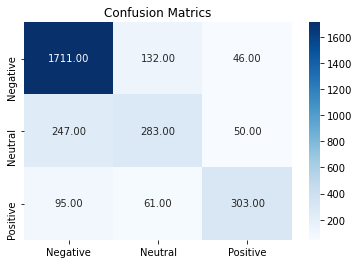

In [63]:
%%time
# Logistic Regression on Character Level 
accuracy4 = evaluate_model(LogisticRegression(C=10, penalty='l2',solver='liblinear'),  X_train_tfidf_ngram_chars, y_train,X_test_tfidf_ngram_chars  , y_test)

In [64]:
results.loc['Logistic Regression'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [65]:
results

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors
Naïve Bayes,0.769809,0.769809,0.702186,0.751708
Logistic Regression,0.797131,0.793033,0.695697,0.784495


### Support Vector Machine

 Accuracy Score for train data = 0.9509050546448088
 Accuracy Score for test data = 0.7786885245901639
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.86      0.87      0.86      1889
           0       0.56      0.55      0.55       580
           1       0.72      0.71      0.72       459

    accuracy                           0.78      2928
   macro avg       0.71      0.71      0.71      2928
weighted avg       0.78      0.78      0.78      2928

Wall time: 465 ms


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


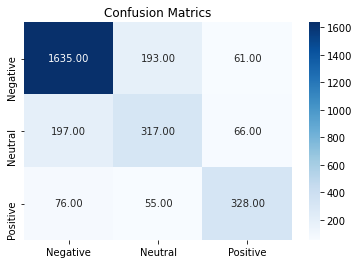

In [66]:
%%time
# Support Vector Machine on Count Vectors

accuracy1 = evaluate_model(LinearSVC(),  X_train_count, y_train,X_test_count , y_test)

 Accuracy Score for train data = 0.9079576502732241
 Accuracy Score for test data = 0.7896174863387978
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.84      0.90      0.87      1889
           0       0.60      0.53      0.56       580
           1       0.75      0.66      0.71       459

    accuracy                           0.79      2928
   macro avg       0.73      0.70      0.71      2928
weighted avg       0.78      0.79      0.78      2928

Wall time: 219 ms


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


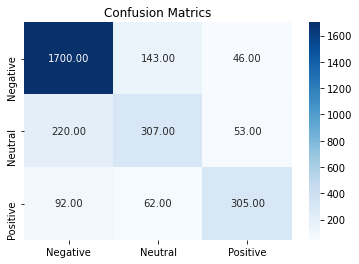

In [67]:
%%time
# Support Vector Machine on Word Level TF IDF Vectors
accuracy2 = evaluate_model(LinearSVC(), X_train_tfidf, y_train, X_test_tfidf,y_test)


 Accuracy Score for train data = 0.7943135245901639
 Accuracy Score for test data = 0.6898907103825137
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.73      0.88      0.80      1889
           0       0.48      0.32      0.38       580
           1       0.62      0.36      0.46       459

    accuracy                           0.69      2928
   macro avg       0.61      0.52      0.55      2928
weighted avg       0.67      0.69      0.66      2928

Wall time: 215 ms


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


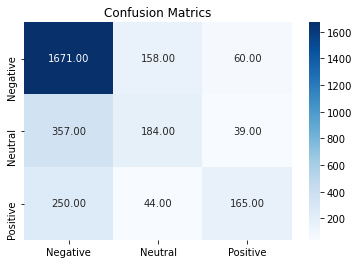

In [68]:
%%time
# Support Vector Machine on Ngram Level TF IDF Vectors
accuracy3 = evaluate_model(LinearSVC(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram,y_test)


 Accuracy Score for train data = 0.8816598360655737
 Accuracy Score for test data = 0.7786885245901639
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.83      0.90      0.86      1889
           0       0.58      0.48      0.52       580
           1       0.74      0.67      0.70       459

    accuracy                           0.78      2928
   macro avg       0.72      0.68      0.70      2928
weighted avg       0.77      0.78      0.77      2928

Wall time: 577 ms


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


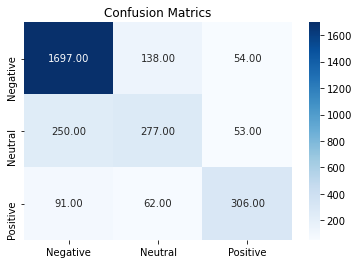

In [69]:
%%time
# Support Vector Machine on Character Level TF IDF Vectors
accuracy4 = evaluate_model(LinearSVC(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars,y_test)


In [70]:
results.loc['Support Vector Machine'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [71]:
results

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors
Naïve Bayes,0.769809,0.769809,0.702186,0.751708
Logistic Regression,0.797131,0.793033,0.695697,0.784495
Support Vector Machine,0.778689,0.789617,0.689891,0.778689


### Bagging Models

#### Count Vectors

In [72]:
%%time
# Bagging (Random Forest) on Count Vectors
modelrf = RandomForestClassifier(n_estimators = 100)
modelrf.fit( X_train_count,y_train)

print(f" Accuracy Score for train data = {modelrf.score( X_train_count , y_train)}")
print(f" Accuracy Score for test data = {modelrf.score(X_test_count, y_test)}")

 Accuracy Score for train data = 0.9930840163934426
 Accuracy Score for test data = 0.7609289617486339
Wall time: 21 s


##### Hyperparameter tuning on Count Vectors

In [73]:
param_grid = {
    'max_depth': [60,80,100,110],
    'min_samples_leaf': [1,3, 4],
    'min_samples_split': [2,3,8],
    'n_estimators': [10,50, 100,150,200]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
best_model = grid_search.fit(X_train_count,y_train)
grid_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 200,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_depth': 100}

 Accuracy Score for train data = 0.9930840163934426
 Accuracy Score for test data = 0.7691256830601093


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Classification Report for test data
              precision    recall  f1-score   support

          -1       0.83      0.89      0.86      1889
           0       0.57      0.51      0.54       580
           1       0.73      0.62      0.67       459

    accuracy                           0.77      2928
   macro avg       0.71      0.67      0.69      2928
weighted avg       0.76      0.77      0.76      2928

Wall time: 21.7 s


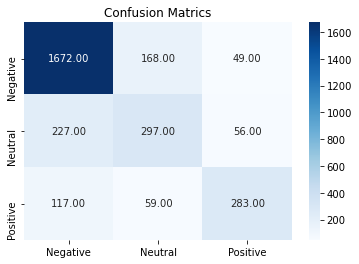

In [74]:
%%time
# Bagging (Random Forest) on Count Vectors
accuracy1 = evaluate_model(RandomForestClassifier( min_samples_leaf=1,min_samples_split=2, n_estimators=100, random_state = 42), X_train_count, y_train, X_test_count,y_test)

#### On Word Level TF IDF Vectors

In [75]:
%%time
# Bagging (Random Forest) on Word Level TF IDF Vectors
modelrwf = RandomForestClassifier(n_estimators = 100)
modelrwf.fit( X_train_tfidf,y_train)

print(f" Accuracy Score for train data = {modelrwf.score( X_train_tfidf , y_train)}")
print(f" Accuracy Score for test data = {modelrwf.score(X_test_tfidf, y_test)}")

 Accuracy Score for train data = 0.991547131147541
 Accuracy Score for test data = 0.764344262295082
Wall time: 10.6 s


##### Hyperparameter tuning On Word Level TF IDF Vectors

In [76]:
param_grid = {
    'max_depth': [70,80,100],
    'min_samples_leaf': [1,3, 4],
    'min_samples_split': [2,3,8],
    'n_estimators': [10,50, 100,150,200]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
best_model = grid_search.fit(X_train_tfidf,y_train)
grid_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 150,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_depth': 80}

 Accuracy Score for train data = 0.9913763661202186
 Accuracy Score for test data = 0.7663934426229508
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.80      0.92      0.86      1889
           0       0.60      0.45      0.51       580
           1       0.75      0.56      0.64       459

    accuracy                           0.77      2928
   macro avg       0.72      0.64      0.67      2928
weighted avg       0.75      0.77      0.75      2928



C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Wall time: 20.1 s


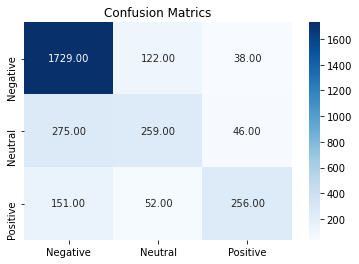

In [77]:
%%time
# Bagging (Random Forest) on Word Level TF IDF Vectors
accuracy2 = evaluate_model(RandomForestClassifier( min_samples_leaf=1,min_samples_split=3, n_estimators=200), X_train_tfidf, y_train, X_test_tfidf,y_test)

#### Bagging (Random Forest) on Ngram Level TF IDF Vectors

In [78]:
%%time
# Bagging (Random Forest) on Ngram Level TF IDF Vectors
modelrnf = RandomForestClassifier(n_estimators = 100)
modelrnf.fit( X_train_tfidf_ngram,y_train)

print(f" Accuracy Score for train data = {modelrnf.score( X_train_tfidf_ngram, y_train)}")
print(f" Accuracy Score for test data = {modelrnf.score(X_test_tfidf_ngram, y_test)}")

 Accuracy Score for train data = 0.8388831967213115
 Accuracy Score for test data = 0.6823770491803278
Wall time: 13.5 s


##### Hyperparameter tuning on Ngram Level TF IDF Vectors

In [79]:
param_grid = {
    'max_depth': [80,100,110],
    'min_samples_leaf': [1,3, 4],
    'min_samples_split': [2,3,8],
    'n_estimators': [100,150,200]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
best_model = grid_search.fit(X_train_tfidf_ngram,y_train)
grid_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 200,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_depth': 110}

 Accuracy Score for train data = 0.8312841530054644
 Accuracy Score for test data = 0.6861338797814208
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.73      0.89      0.80      1889
           0       0.48      0.31      0.37       580
           1       0.62      0.34      0.44       459

    accuracy                           0.69      2928
   macro avg       0.61      0.51      0.54      2928
weighted avg       0.66      0.69      0.66      2928



C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Wall time: 11.5 s


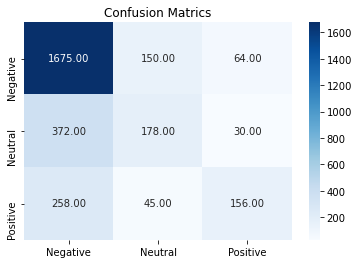

In [80]:
%%time
# Bagging (Random Forest) on Ngram Level TF IDF Vectors
accuracy3 = evaluate_model(RandomForestClassifier( min_samples_leaf=1,min_samples_split=8, n_estimators=100), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram,y_test)

#### Bagging (Random Forest) on  on Character Level TF IDF Vectors

In [81]:
%%time
# Bagging (Random Forest) on Character Level TF IDF Vectors
modelrf = RandomForestClassifier(n_estimators = 100)
modelrf.fit( X_train_tfidf_ngram_chars,y_train)

print(f" Accuracy Score for train data = {modelrf.score( X_train_tfidf_ngram_chars , y_train)}")
print(f" Accuracy Score for test data = {modelrf.score(X_test_tfidf_ngram_chars, y_test)}")

 Accuracy Score for train data = 0.9940232240437158
 Accuracy Score for test data = 0.7407786885245902
Wall time: 16.9 s


#### Hyperparameter tuning on  on Character Level TF IDF Vectors

In [82]:
param_grid = {
    'max_depth': [110,120,140,150],
    'min_samples_leaf': [1,3, 4],
    'min_samples_split': [2,3,8],
    'n_estimators': [100,150,200,250,300]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
best_model = grid_search.fit(X_train_tfidf_ngram_chars ,y_train)
grid_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 200,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_depth': 140}

 Accuracy Score for train data = 0.9940232240437158
 Accuracy Score for test data = 0.7431693989071039
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.75      0.95      0.84      1889
           0       0.63      0.28      0.39       580
           1       0.76      0.47      0.58       459

    accuracy                           0.74      2928
   macro avg       0.72      0.57      0.61      2928
weighted avg       0.73      0.74      0.71      2928



C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Wall time: 31.6 s


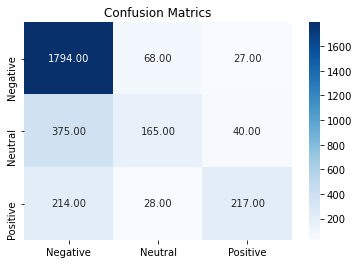

In [83]:
%%time
# Bagging (Random Forest) on  on Character Level TF IDF Vectors
accuracy4 = evaluate_model(RandomForestClassifier( min_samples_leaf=1,min_samples_split=3, n_estimators=200), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars,y_test)

In [84]:
results.loc['Random Forest'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

### Boosting Models

In [85]:
%%time
# Gradient Boosting on Count Vectors
modelrf = GradientBoostingClassifier()
modelrf.fit( X_train_count,y_train)

print(f" Accuracy Score for train data = {modelrf.score( X_train_count , y_train)}")
print(f" Accuracy Score for test data = {modelrf.score(X_test_count, y_test)}")

 Accuracy Score for train data = 0.7357411202185792
 Accuracy Score for test data = 0.7370218579234973
Wall time: 38.6 s


In [86]:
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the Random search model
grid_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
best_model = grid_search.fit(X_train_count,y_train)
grid_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 120}

 Accuracy Score for train data = 0.9930840163934426
 Accuracy Score for test data = 0.75
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.81      0.87      0.84      1889
           0       0.57      0.46      0.51       580
           1       0.65      0.61      0.63       459

    accuracy                           0.75      2928
   macro avg       0.68      0.65      0.66      2928
weighted avg       0.74      0.75      0.74      2928



C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Wall time: 5min 10s


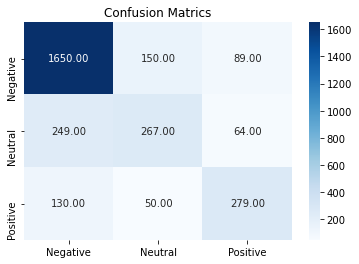

In [87]:
%%time
# Gradient Boosting on Count Vectors
accuracy1 = evaluate_model(GradientBoostingClassifier(max_depth=150, min_samples_leaf=1,min_samples_split=3, n_estimators=100), X_train_count, y_train, X_test_count,y_test)

In [88]:
%%time
# Gradient Boosting on Word Level TF IDF Vectors
modelrf = GradientBoostingClassifier()
modelrf.fit( X_train_tfidf,y_train)

print(f" Accuracy Score for train data = {modelrf.score( X_train_tfidf , y_train)}")
print(f" Accuracy Score for test data = {modelrf.score(X_test_tfidf, y_test)}")

 Accuracy Score for train data = 0.7482923497267759
 Accuracy Score for test data = 0.7414617486338798
Wall time: 11.2 s


In [89]:
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the Random search model
grid_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
best_model = grid_search.fit(X_train_tfidf,y_train)
grid_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 150}

 Accuracy Score for train data = 0.991547131147541
 Accuracy Score for test data = 0.7547814207650273
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.80      0.91      0.85      1889
           0       0.59      0.41      0.48       580
           1       0.68      0.55      0.61       459

    accuracy                           0.75      2928
   macro avg       0.69      0.62      0.65      2928
weighted avg       0.74      0.75      0.74      2928



C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


GB, WordLevel TF-IDF : 0.7548

Wall time: 12min 56s


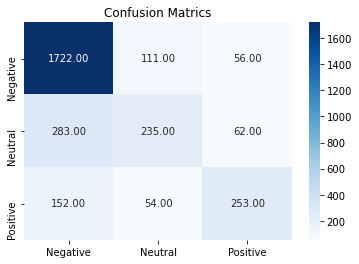

In [90]:
%%time
# Gradient Boosting on Word Level TF IDF Vectors
accuracy2 = evaluate_model(GradientBoostingClassifier(max_depth=150, min_samples_leaf=1,min_samples_split=2, n_estimators=250), X_train_tfidf, y_train, X_test_tfidf,y_test)
print('GB, WordLevel TF-IDF : %.4f\n' % accuracy2)

 Accuracy Score for train data = 0.6649590163934426
 Accuracy Score for test data = 0.6728142076502732
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.68      0.97      0.80      1889
           0       0.54      0.13      0.20       580
           1       0.84      0.12      0.21       459

    accuracy                           0.67      2928
   macro avg       0.68      0.41      0.40      2928
weighted avg       0.67      0.67      0.59      2928

GB, N-Gram Vectors   : 0.6728

Wall time: 4.07 s


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


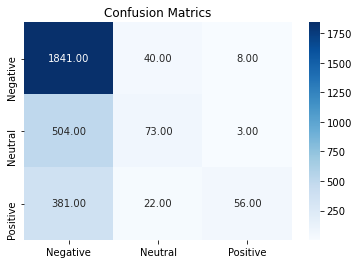

In [91]:
%%time
# Gradient Boosting on Ngram Level TF IDF Vectors
accuracy3 = evaluate_model(GradientBoostingClassifier(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram,y_test)
print('GB, N-Gram Vectors   : %.4f\n' % accuracy3)

 Accuracy Score for train data = 0.780396174863388
 Accuracy Score for test data = 0.7459016393442623
Classification Report for test data
              precision    recall  f1-score   support

          -1       0.77      0.92      0.84      1889
           0       0.57      0.32      0.41       580
           1       0.74      0.56      0.64       459

    accuracy                           0.75      2928
   macro avg       0.70      0.60      0.63      2928
weighted avg       0.73      0.75      0.72      2928

GB, CharLevel Vectors: 0.7459

Wall time: 1min 14s


C:\Users\SULAKKHANA\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


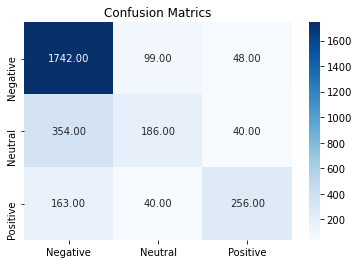

In [95]:
%%time
# Gradient Boosting on Character Level TF IDF Vectors
accuracy4 = evaluate_model(GradientBoostingClassifier(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars,y_test)
print('GB, CharLevel Vectors: %.4f\n' % accuracy4)

In [96]:
results.loc['Gradient Boosting'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [97]:
results

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors
Naïve Bayes,0.769809,0.769809,0.702186,0.751708
Logistic Regression,0.797131,0.793033,0.695697,0.784495
Support Vector Machine,0.778689,0.789617,0.689891,0.778689
Random Forest,0.769126,0.766393,0.686134,0.743169
Gradient Boosting,0.750000,0.754781,0.672814,0.745902
